#Problème n°1

La bonne transmission de signaux électromagnétiques dans l'atmosphère peut dépendre de la météo. La pluie affecte notoirement les échanges entre les antennes relais des réseaux mobiles actuels. C'est une gêne, mais aussi une opportunité: l'atténuation des ondes électromagnétiques due à la pluie peut être mesurée et utilisée comme un moyen de quantifier les précipitations.

Dans ce problème, on s'intéresse à la conversion de l'atténuation, définie comme un rapport entre puissance émise et puissance reçue et exprimée en dB, en un taux de pluie moyen le long de segments physiques dont les extrémités sont des paires d'antennes relais.

Evidemment, d'autres éléments que le pluie, plus ou moins bien connus, peuvent influencer l'atténuation. La simulation sur laquelle nous allons travailler, qui porte sur un millier de paires d'antennes virtuelles, est construite de la façon suivante:

- pour une paire d'antennes donnée, on modélise une série temporelle de taux de pluie moyen par un processus stochastique dont les paramètres dépendent entre autres de la distance qui sépare les antennes.
- pour en tirer des atténuations, on applique à cette série les transformations suivantes:
    - un filtre convolutif, censé modéliser l'impact du film d'eau se formant sur les antennes au cours d'un épisode de pluie.
    - une conversion non-linéaire, tirée d'un modèle physique, est appliquée composante à composante.
 épisode pluvieux (ce film qui s'épaissit augmente progressivement l'atténuation).
    - un bruit haute-fréquence
    - un bruit basse fréquence

La cellules suivantes permettent de récupérer les briques de code utiles, de construire un dictionnaire contenant des identifiants de paires d'antennes (clefs) et les distances les séparant (valeurs). La dernière cellule montre des exemples de séries temporelles simulées pour quelques paires.

In [1]:
# Local clone
! git clone https://github.com/Redazh/exam_2025.git
! cp exam_2025/utils/utils_probleme1.py .

Cloning into 'exam_2025'...
remote: Enumerating objects: 79, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 79 (delta 15), reused 10 (delta 10), pack-reused 58 (from 1)
Receiving objects: 100% (79/79), 1.42 MiB | 3.54 MiB/s, done.
Resolving deltas: 100% (27/27), done.


In [2]:
# Imports
from os.path import join, isdir, isfile
from os import listdir as ls
import copy
import torch
import numpy as np
import sys
from utils_probleme1 import create_dataloader

In [3]:
# Dictionnaire des "distances" (générées au hasard)
idx2distance_train = {i: 0.2 +  1.8 * torch.rand((1,)).item() for i in range(0, 1000)}
idx2distance_val = {i: 0.2 +  1.8 * torch.rand((1,)).item() for i in range(1000, 1200)}

# Paramètres de la simulation
duration = 4096  # durée de la série temporelle (unité : minutes)
batch_size = 100  # taille d'un échantillon

# Création du dataloader (il contient toutes les étapes de la simulation)
# (en une époque, chaque paire d'antennes du dictionnaire idx2distance
# a été tirée exactement une fois)
trainloader = create_dataloader(duration, idx2distance_train, batch_size)

# Génération d'un batch contenant des séries temporelles
for batch_idx, (ids, dists, rain_rates, attenuations) in enumerate(trainloader):
    break

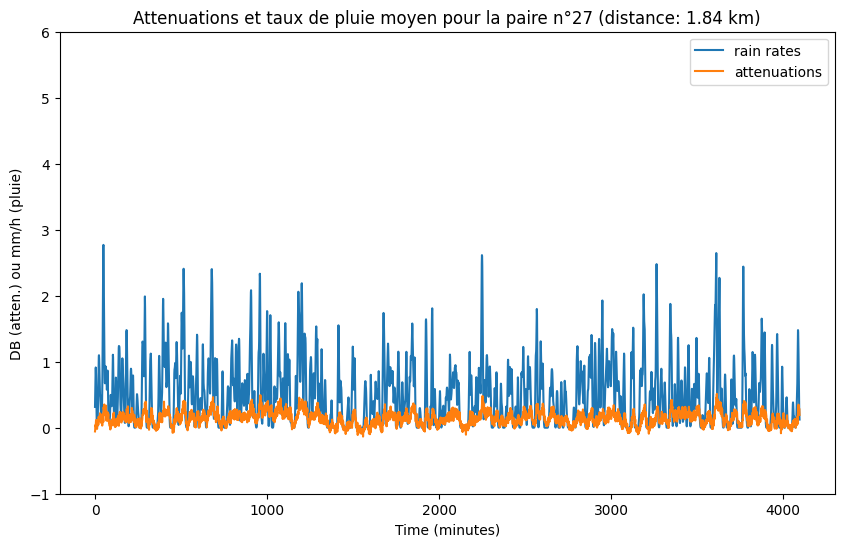

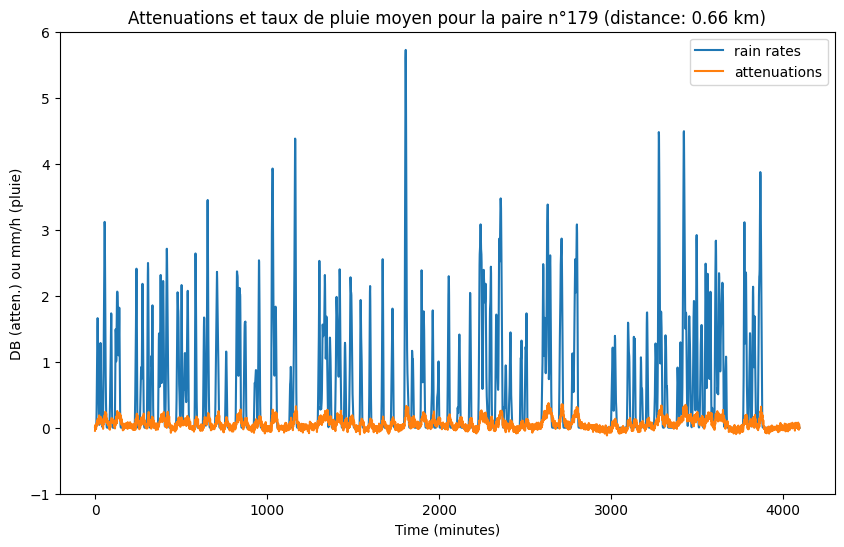

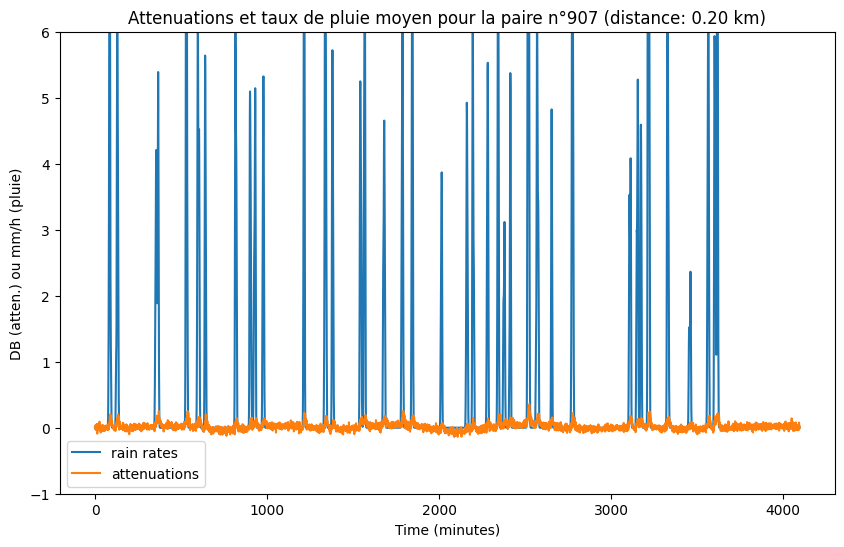

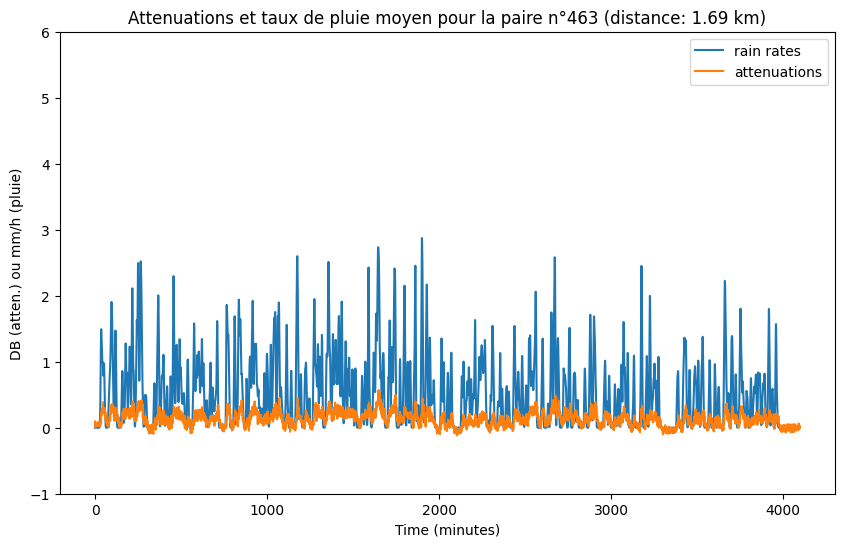

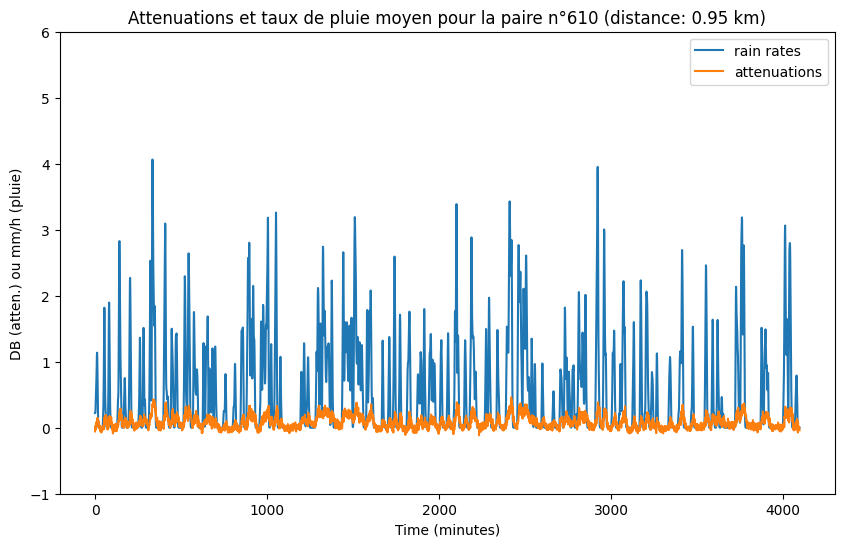

In [4]:
import matplotlib.pyplot as plt

for k in range(5):
  plt.figure(figsize=(10, 6))
  plt.plot(np.arange(duration), rain_rates[k], label='rain rates')
  plt.plot(np.arange(duration), attenuations[k], label='attenuations')
  plt.title(f"Attenuations et taux de pluie moyen pour la paire n°{ids[k].item():.0f} (distance: {dists[k].item():.2f} km)")
  plt.xlabel('Time (minutes)')
  plt.ylabel('DB (atten.) ou mm/h (pluie)')
  plt.ylim(-1,6)
  plt.legend()
  plt.show()

## Partie I : Un réseau de neurones générique

# A partir des briques de base

Dans cette partie, on entraîne un UNet1D à faire le lien entre atténuations
et taux de pluie. Les cellules suivantes contiennent les blocs du UNet1D et son montage :

In [6]:
##############################################################################################
################################     UNet 1D building blokcs    ##############################
import torch
import torch.nn as nn
import torch.nn.functional as F

class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm1d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv1d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm1d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x

class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(Down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool1d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class Up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=False):
        super(Up, self).__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear')
        else:
            self.up = nn.ConvTranspose1d(in_ch, in_ch, kernel_size=2, stride=2)

        self.conv = double_conv(2*in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffX = x1.size()[2] - x2.size()[2]
        x2 = F.pad(x2, (diffX // 2, int(diffX / 2)))

        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv1d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x


################################################################################
######################################## class UNet1D ##########################

class UNet1D(nn.Module):
    def __init__(self, n_channels, n_classes, size=64):
        super(UNet1D, self).__init__()
        self.inc = inconv(n_channels, size)
        self.down1 = Down(size, 2*size)
        self.down2 = Down(2*size, 4*size)
        self.down3 = Down(4*size, 8*size)
        self.down4 = Down(8*size, 8*size)
        self.up1 = Up(8*size, 4*size)
        self.up2 = Up(4*size, 2*size)
        self.up3 = Up(2*size, size)
        self.up4 = Up(size, size)
        self.outc = outconv(size, n_classes)
        self.n_classes=n_classes

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        del x4, x5
        x = self.up2(x, x3)
        del x3
        x = self.up3(x, x2)
        del x2
        x = self.up4(x, x1)
        del x1
        x = self.outc(x)
        return   x

**Consignes:** \
1) Entraîner sur GPU un UNet 1D à restituer les taux de pluie à partir des atténuations.
- On utilisera la MSE comme fonction de coût et comme score. Dans les deux cas, prendre une marge de deux heures au début et à la fin de la série temporelle pour éviter les effets de bord.
- La descente de gradient stochastique sera pilotée par l'optimiseur ADAM (paramétrage standard) sur cinquante époques.

2) Tracer la courbe d'apprentissage de manière à montrer l'évolution:
- des performances en généralisation sur de nouvelles données issues des paires d'antennes vues à l'entraînement.
- des performances en généralisation sur des séries issues de paires d'antennes indépendantes (celles de *idx2distance_val*).


3) Visualiser les prédictions après apprentissage

In [10]:
# Création du dataloader pour la validation
valloader = create_dataloader(duration, idx2distance_val, batch_size)


In [7]:
import torch.optim as optim
# Paramètres
n_channels = 1  # Une seule série temporelle en entrée (atténuations)
n_classes = 1   # Une seule série temporelle en sortie (taux de pluie)
batch_size = 100
num_epochs = 50
size = 32  # Taille initiale des canaux

# Initialisation du modèle
model = UNet1D(n_channels, n_classes, size=size)

# Utilisation du GPU si disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)

# Définition de la fonction de coût (MSE) et de l'optimiseur (ADAM)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


cuda


In [15]:
for batch_idx, (ids, dists, rain_rates, attenuations) in enumerate(valloader):
  print(attenuations.shape)
  print((attenuations.to(device)).shape)
  break

torch.Size([100, 4096])
torch.Size([100, 4096])


In [16]:
# Boucles d'entraînement et de validation
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for batch_idx, (ids, dists, rain_rates, attenuations) in enumerate(trainloader):
        attenuations = attenuations.to(device)  # Entrée (atténuations)
        rain_rates = rain_rates.to(device)      # Cible (taux de pluie)

        # Marges pour éviter les effets de bord (2 heures = 120 minutes)
        attenuations = attenuations[:, 120:-120]  # Ajusté pour la bonne dimension
        rain_rates = rain_rates[:, 120:-120]      # Ajusté pour la bonne dimension

        # Ajout de la dimension "channel" pour correspondre au modèle
        attenuations = attenuations.unsqueeze(1)  # Devient (batch size, 1, sequence length)
        rain_rates = rain_rates.unsqueeze(1)      # Devient (batch size, 1, sequence length)

        # Forward pass
        outputs = model(attenuations)
        loss = criterion(outputs, rain_rates)

        # Backward pass et mise à jour des poids
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_idx, (ids, dists, rain_rates, attenuations) in enumerate(valloader):
            attenuations = attenuations.to(device)
            rain_rates = rain_rates.to(device)

            # Marges pour éviter les effets de bord
            attenuations = attenuations[:, 120:-120]
            rain_rates = rain_rates[:, 120:-120]

            attenuations = attenuations.unsqueeze(1)
            rain_rates = rain_rates.unsqueeze(1)

            outputs = model(attenuations)
            loss = criterion(outputs, rain_rates)
            val_loss += loss.item()

    # Stockage des pertes
    train_losses.append(train_loss / len(trainloader))
    val_losses.append(val_loss / len(valloader))

    # Affichage de l'évolution des pertes
    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")


Epoch [1/50], Train Loss: 0.1535, Val Loss: 0.5186
Epoch [2/50], Train Loss: 0.1470, Val Loss: 0.2720
Epoch [3/50], Train Loss: 0.1402, Val Loss: 0.1914
Epoch [4/50], Train Loss: 0.1395, Val Loss: 0.1532
Epoch [5/50], Train Loss: 0.1408, Val Loss: 0.1666
Epoch [6/50], Train Loss: 0.1408, Val Loss: 0.1499
Epoch [7/50], Train Loss: 0.1384, Val Loss: 0.1389
Epoch [8/50], Train Loss: 0.1389, Val Loss: 0.1366
Epoch [9/50], Train Loss: 0.1350, Val Loss: 0.1380
Epoch [10/50], Train Loss: 0.1359, Val Loss: 0.1593
Epoch [11/50], Train Loss: 0.1370, Val Loss: 0.1348
Epoch [12/50], Train Loss: 0.1340, Val Loss: 0.1369
Epoch [13/50], Train Loss: 0.1345, Val Loss: 0.1281
Epoch [14/50], Train Loss: 0.1381, Val Loss: 0.1314
Epoch [15/50], Train Loss: 0.1344, Val Loss: 0.1291
Epoch [16/50], Train Loss: 0.1330, Val Loss: 0.1327
Epoch [17/50], Train Loss: 0.1339, Val Loss: 0.1280
Epoch [18/50], Train Loss: 0.1320, Val Loss: 0.1324
Epoch [19/50], Train Loss: 0.1324, Val Loss: 0.1375
Epoch [20/50], Train 

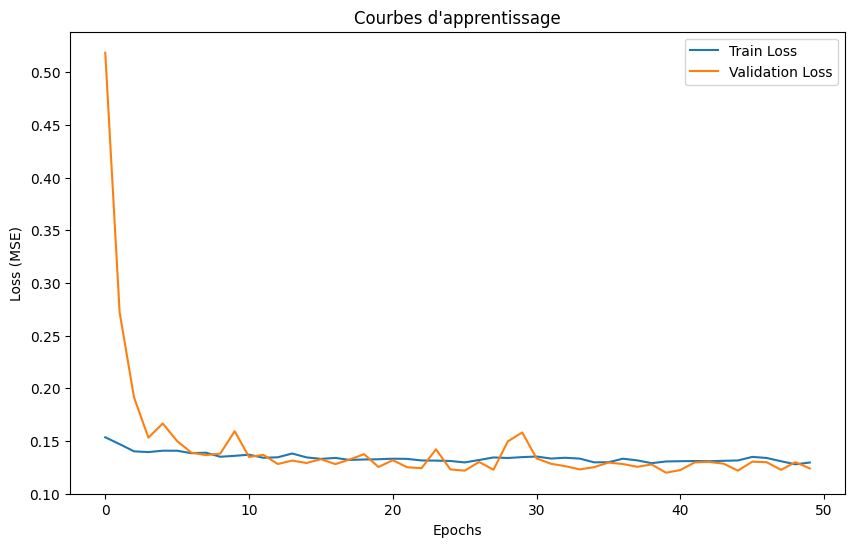

In [17]:
# Tracé des courbes d'apprentissage
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Courbes d'apprentissage")
plt.legend()
plt.show()


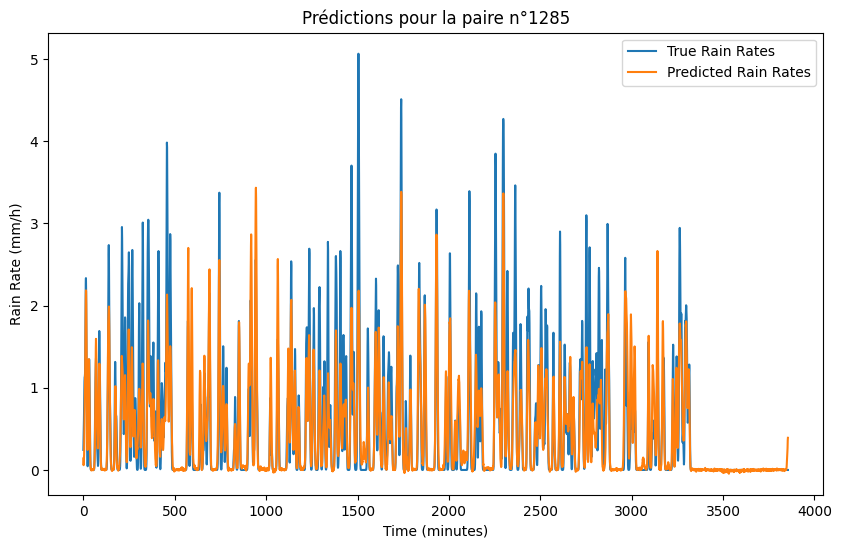

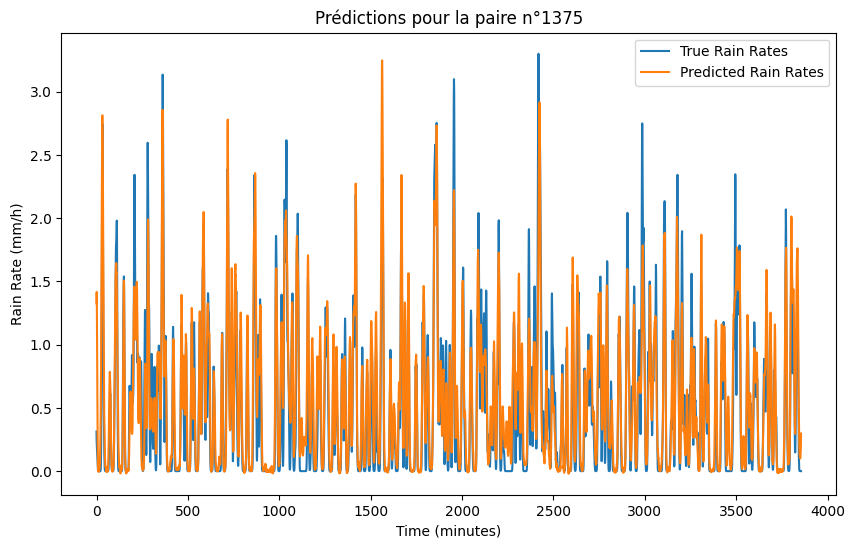

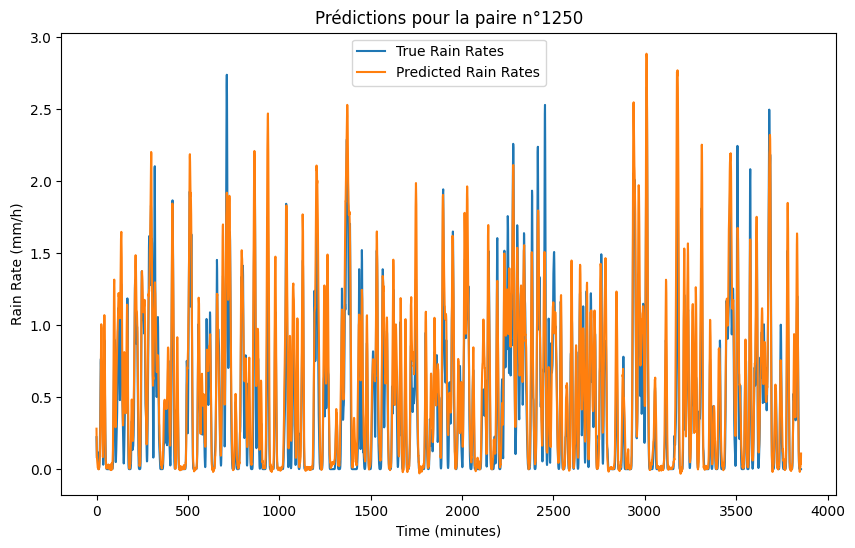

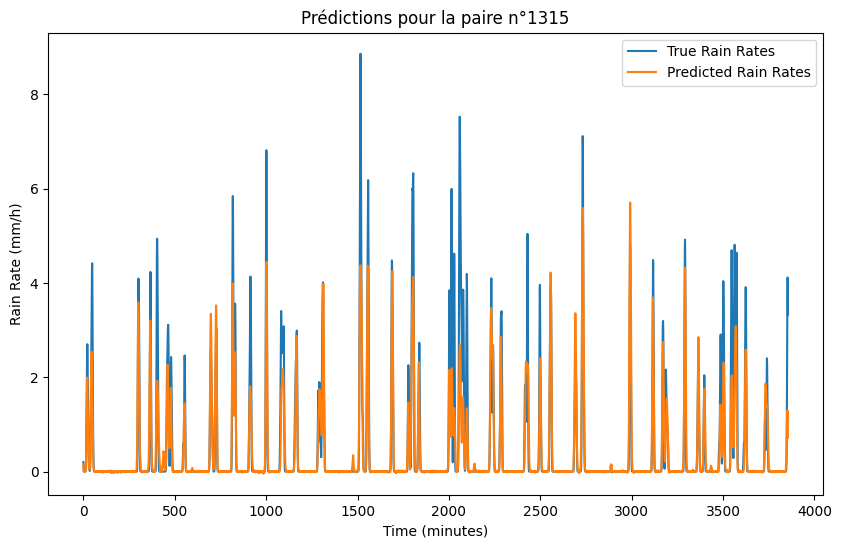

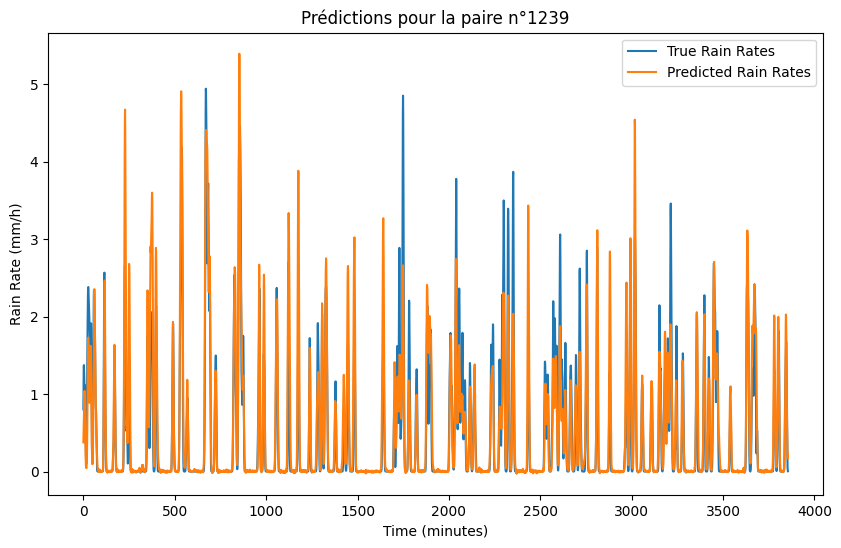

In [19]:
# Création du dictionnaire des distances pour le test
idx2distance_test = {i: 0.2 + 1.8 * torch.rand((1,)).item() for i in range(1200, 1400)}

# Création du dataloader pour le test
testloader = create_dataloader(duration, idx2distance_test, batch_size)

model.eval()  # Mode évaluation
with torch.no_grad():
    for batch_idx, (ids, dists, rain_rates, attenuations) in enumerate(testloader):
        attenuations = attenuations.to(device)
        rain_rates = rain_rates.to(device)

        # Marges pour éviter les effets de bord
        attenuations = attenuations[:, 120:-120]
        rain_rates = rain_rates[:, 120:-120]

        # Ajout de la dimension "channel"
        attenuations = attenuations.unsqueeze(1)
        rain_rates = rain_rates.unsqueeze(1)

        # Prédictions
        predictions = model(attenuations)

        # Visualisation pour quelques exemples
        for k in range(5):
            plt.figure(figsize=(10, 6))
            plt.plot(rain_rates[k].squeeze().cpu().numpy(), label="True Rain Rates")
            plt.plot(predictions[k].squeeze().cpu().numpy(), label="Predicted Rain Rates")
            plt.title(f"Prédictions pour la paire n°{ids[k].item()}")
            plt.xlabel("Time (minutes)")
            plt.ylabel("Rain Rate (mm/h)")
            plt.legend()
            plt.show()

        break


## Partie II

Dans la première partie, le modèle était générique: la specificité de la paire d'antenne n'était pas prise en compte. On se propose de le faire en combinant un réseau générique à un perceptron spécifique, de sorte que la sortie $Z$ s'exprime sous la forme: \
$$Z = F(X, k) = f^{\tiny{Perceptron}}_{\alpha_k}(f^{\tiny{UNet}}_{\theta}(X))$$ \
 où $f^{\tiny{UNet}}_{\theta}(.)$ représente la fonction *forward* d'un UNet et $f^{\tiny{Perceptron}}_{\alpha_k}(.)$, la fonction forward du perceptron associé à la paire d'antennes d'identifiant $k$. \

Il s'agit donc en premier lieu d'adjoindre au UNet de la partie I autant de perceptrons que le jeu d'entraînement compte de paires d'antennes, ce qui se fait grâce aux lignes suivantes:

In [ ]:
# Pour l'ajout de 1200 perceptrons à deux couches:
self.num_pairs = 1200
self.input_size_fc_layer = 5
self.hidden_size_fc_layer = 5
# Liste des premières couches
self.linears1 = nn.ModuleList([nn.Linear(self.input_size_fc_layer,
                                         self.hidden_size_fc_layer) for i in range(self.num_pairs)])
# Liste des secondes couches
self.linears2 = nn.ModuleList([nn.Linear(self.hidden_size_fc_layer,
                                         1) for i in range(self.num_pairs)])


**Consignes:** \
1) Définir une nouvelle classe de réseau en modifiant la classe UNet1D (dans utils_probleme1.py).
Ajouter ces perceptrons au réseau.

2) Fixer *self.n_classes* de façon à ce que la sortie du UNet soit compatible avec l'entrée du perceptron.

3) Modifications de la fonction forward:
- elle doit prendre comme arguments un batch d'entrées et un batch d'identifiants.

- après les étapes propres au UNet, elle doit appliquer le perceptron d'indice k à une série provenant de la paire n°k. La cellule de code suivante fournit un exemple dont on pourra directement s'inspirer.

4) Suivre les performances en généralisation sur les paires d'antennes du jeu d'entraînement et sur les deux cents paires de validation. Commenter.




In [ ]:
def apply_perceptron(self, UNet_output, ids):
    for i in range(ids.shape[0]):
        id = ids[i]
        # application de la première couche
        x = self.linears1[id](UNet_output[i].transpose(0,1).contiguous())
        x = self.relu(x)
        # application de la seconde couche
        x = self.linears2[id](x)
        # correction multiplicative de UNet_output
        UNet_output[i, 0] *= 1 + x.transpose(0,1).contiguous()
    return UNet_output[:,0]


## Partie III

La solution proposée dans la partie II a un défaut: les performances chutent sur les paires d'antennes qui n'ont pas été rencontrées pendant l'entraînement. Pour le corriger, on se propose de suivre la méthode suivante:
- ajouter un perceptron "générique" de même architecture que les perceptrons spécifiques.
- entraîner le réseau de la partie II en remplaçant une fois sur quatre l'identifiant de la paire d'antennes par l'indice du perceptron générique.
- après cinquante époques, geler les poids de la partie générique et prolonger l'apprentissage des perceptrons spécifiques sur une vingtaine d'époque.

**Consignes:** \

1) Mettre en oeuvre cette méthode

2) Conclure sur son efficacité